In [1]:
import redis
import json

# Define connection variables
host = 'redis-13857.c14.us-east-1-2.ec2.redns.redis-cloud.com'
port = 13857
password = 'okNaqK7r5dKE6stSis0FlUuiDlhH2t7M'

# Connect to Redis
r = redis.Redis(host=host, port=port, password=password, decode_responses=True)
print('Connected to Redis')

r.flushdb()

Connected to Redis


True

# Order Tracking and Notifications

## Description of the use case
This use case involves tracking the status of orders in real-time and sending notifications to customers at various stages of the order process. This ensures that customers are kept informed about their order status, improving their overall experience.

## Redis Data Structures Used
- **Hashes**: To store order information and statuses.
- **Streams**: To capture and process real-time order updates.
- **Pub/Sub**: To send notifications to customers.

In [2]:
# To see real time notifications, follow the below

# Connect via redis-cli
# redis-cli -h redis-13857.c14.us-east-1-2.ec2.redns.redis-cloud.com -p 13857 -a okNaqK7r5dKE6stSis0FlUuiDlhH2t7M
# Issue the below command to monitor the notification channels
# PSUBSCRIBE notifications:*

In [3]:
# Mock data for the use case
mock_data = {
    'order_1001': {'customer_id': 'cust_1', 'status': 'processing'},
    'order_1002': {'customer_id': 'cust_2', 'status': 'shipped'},
    'order_1003': {'customer_id': 'cust_3', 'status': 'delivered'},
}

# Use Hashes to store order information and statuses
for order_id, order_info in mock_data.items():
    r.hset(order_id, mapping=order_info)

# Use Streams to capture real-time order updates
r.xadd('order_updates', {'order_id': 'order_1001', 'status': 'shipped'})
r.xadd('order_updates', {'order_id': 'order_1002', 'status': 'delivered'})

# Function to process order updates and send notifications
def process_order_updates():
    stream_entries = r.xrange('order_updates')
    for entry in stream_entries:
        order_id = entry[1]['order_id']
        new_status = entry[1]['status']
        r.hset(order_id, 'status', new_status)
        customer_id = r.hget(order_id, 'customer_id')
        r.publish(f'notifications:{customer_id}', f'Your order {order_id} is now {new_status}')


# Process the order updates
process_order_updates()

# Print the updated order information
for order_id in mock_data.keys():
    print(f"{order_id}: {r.hgetall(order_id)}")

order_1001: {'customer_id': 'cust_1', 'status': 'shipped'}
order_1002: {'customer_id': 'cust_2', 'status': 'delivered'}
order_1003: {'customer_id': 'cust_3', 'status': 'delivered'}


### A sample output of notifications on redis-cli

You can implement a notification microservices in a different python file by using the below code as well

```python
def listen_for_notifications(customer_id):
    pubsub = r.pubsub()
    pubsub.subscribe(f'notifications:{customer_id}')
    print(f'Listening for notifications for customer {customer_id}...')
    for message in pubsub.listen():
        if message['type'] == 'message':
            print(f'Notification for customer {customer_id}: {message['data']}')

listen_for_notifications('cust_1')
```

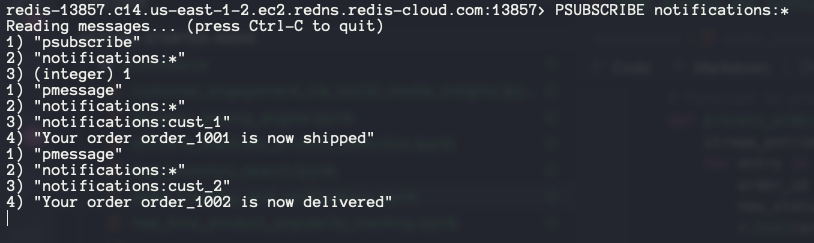